In [1]:
import numpy as np
import einops

In [2]:
def F_norm(tensor):
    return np.sum(tensor ** 2)

def truncatedSVD(A, delta):
    u, s, v = np.linalg.svd(A)
    rank = (np.abs(s) >= delta).sum()
    return u[:, :rank], s[:rank], v[:rank, :]

def numel(tensor):
    return tensor.size

In [28]:
def TTsvd(tensor, eps):
    d = len(tensor.shape)
    delta = eps / np.sqrt(d - 1) * F_norm(tensor)
    Ctens = tensor.copy()
    
    rk = 1
    r_prev = 1

    G_list = []
    for k in range(1, d):
        Ctens = Ctens.reshape(r_prev * tensor.shape[k - 1], numel(Ctens) // (r_prev * tensor.shape[k - 1]))
        u, s, v = truncatedSVD(Ctens, delta)
        rk = len(s)
        if k > 1:
            Gk = u.reshape(r_prev, tensor.shape[k - 1], rk)
        else:
            Gk = u.reshape(tensor.shape[k - 1], rk)
        G_list.append(Gk)
        r_prev = rk
        Ctens =  np.diag(s) @ v
    G_list.append(Ctens)
    #G_list.append(Ctens.reshape(r_prev, Ctens.shape[1] // tensor.shape[-1], tensor.shape[-1]))
    return G_list
    

In [29]:
from PIL import Image
import numpy as np

# Загружаем jpg картинку при помощи PIL
image = Image.open('amanita.jpg')

# Переводим картинку в массив numpy
image_array = np.array(image)
image_array = einops.reduce(image_array[1:, 1:, :].astype('float'), "(h 4) (w 4) c -> h w c", 'mean')
"""[1:, 1:]
image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
image_array = einops.reduce(image_array, "(h 4) (w 4) c -> h w c", 'mean')"""

# Проверяем размерность массива
print(image_array.shape)

(56, 56, 3)


In [31]:
import matplotlib.pyplot as plt

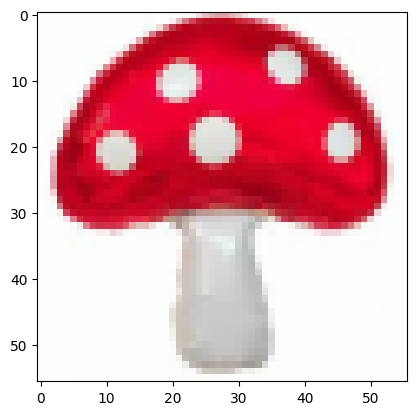

In [32]:
tensor_train = TTsvd(image_array, 1e-8)
rec = einops.einsum(tensor_train[0], tensor_train[1], tensor_train[2], "i alpha, alpha j beta, beta k -> i j k")
plt.imshow((rec - rec.min()) / (rec.max() - rec.min()))

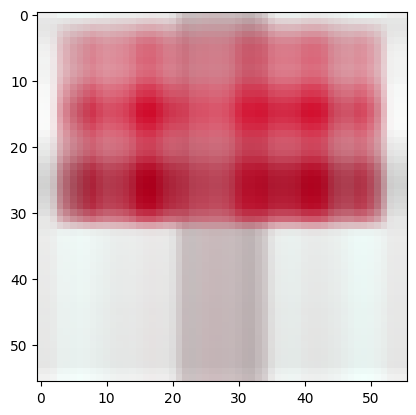

In [38]:
tensor_train = TTsvd(image_array, 1e-5)
rec = einops.einsum(tensor_train[0], tensor_train[1], tensor_train[2], "i alpha, alpha j beta, beta k -> i j k")
plt.imshow((rec - rec.min()) / (rec.max() - rec.min()))